In [1]:
from datetime import datetime
import math
import cv2
import glob
import numpy as np
from numpy import zeros, ones, vstack, hstack
from numpy.random import permutation
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity as ssim

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  fratzcan


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization


100%|██████████| 192M/192M [00:00<00:00, 1.22GB/s]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
import wandb
wandb.login(key = "4d975cec314dd2bfa52914355589e22b23c1fc6e")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: firatozc (firatozc-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):
    R = R0 / 255
    G = G0 / 255
    B = B0 / 255

    Y = 0.299*R + 0.587*G + 0.114*B
    X = 0.449*R + 0.353*G + 0.198*B
    Z = 0.012*R + 0.089*G + 0.899*B

    L = Y
    a = (X - Y) / 0.234
    b = (Y - Z) / 0.785

    return L, a, b

## convert the personal LAB (LAB2) to RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R G B [0 255]
def LAB22RGB(L, a, b):
    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0 = np.zeros((L.shape[0], 3))
    C0[:, 0] = L[:, 0]
    C0[:, 1] = a[:, 0]
    C0[:, 2] = b[:, 0]
    C = np.transpose(C0)

    X = np.linalg.inv(aa).dot(C)
    X1D = np.reshape(X, (X.shape[0]*X.shape[1], 1))
    p0 = np.where(X1D < 0)
    X1D[p0[0]] = 0
    p1 = np.where(X1D > 1)
    X1D[p1[0]] = 1
    Xr = np.reshape(X1D, (X.shape[0], X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint8(np.round(Rr * 255))
    G = np.uint8(np.round(Gr * 255))
    B = np.uint8(np.round(Br * 255))
    return R, G, B

In [6]:
def psnr(img1, img2):
    mse = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def mae(imageA, imageB, bands):
    err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def rmse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    err = np.sqrt(err)
    return err

In [7]:
class DoubleConv(nn.Module):
    """Double Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [8]:
class TripleConv(nn.Module):
    """Triple Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.triple_conv(x)


In [9]:
class UNet1(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNet1, self).__init__()

        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = TripleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = TripleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = TripleConv(512, 512)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv55 = TripleConv(512, 512)

        # Decoder
        self.up66 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv66 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up6 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)  # 256 + 256 from skip connection

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)  # 128 + 128 from skip connection

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)  # 64 + 64 from skip connection

        # Multi-scale feature fusion
        self.up_f02 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_f12 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final layers
        self.conv11 = nn.Conv2d(384, 128, kernel_size=3, padding=1)  # 64+64+128+128
        self.relu11 = nn.ReLU(inplace=True)

        self.conv12 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU(inplace=True)

        self.conv13 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU(inplace=True)

        self.conv14 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        x1 = self.pool1(conv1)

        conv2 = self.conv2(x1)
        x2 = self.pool2(conv2)

        conv3 = self.conv3(x2)
        x3 = self.pool3(conv3)

        conv4 = self.conv4(x3)
        x4 = self.pool4(conv4)

        conv5 = self.conv5(x4)
        x5 = self.pool5(conv5)

        # Bottleneck
        conv55 = self.conv55(x5)

        # Decoder
        up66 = self.up66(conv55)
        if up66.size()[2:] != conv5.size()[2:]:
            up66 = F.interpolate(up66, size=conv5.size()[2:], mode="bilinear", align_corners=True)
        merge66 = torch.cat([conv5, up66], dim=1)
        conv66 = self.conv66(merge66)

        up6 = self.up6(conv66)
        if up6.size()[2:] != conv4.size()[2:]:
            up6 = F.interpolate(up6, size=conv4.size()[2:], mode="bilinear", align_corners=True)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.conv6(merge6)

        up7 = self.up7(conv6)
        if up7.size()[2:] != conv3.size()[2:]:
            up7 = F.interpolate(up7, size=conv3.size()[2:], mode="bilinear", align_corners=True)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.conv7(merge7)

        up8 = self.up8(conv7)
        if up8.size()[2:] != conv2.size()[2:]:
            up8 = F.interpolate(up8, size=conv2.size()[2:], mode="bilinear", align_corners=True)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.conv8(merge8)

        up9 = self.up9(conv8)
        if up9.size()[2:] != conv1.size()[2:]:
            up9 = F.interpolate(up9, size=conv1.size()[2:], mode="bilinear", align_corners=True)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.conv9(merge9)


        # Multi-scale feature fusion
        up_f01 = conv1  # Original resolution
        up_f11 = conv9  # Decoded features
        up_f02 = self.up_f02(conv2)  # Upsampled encoder features
        up_f12 = self.up_f12(conv8)  # Upsampled decoder features

        # Concatenate multi-scale features
        merge11 = torch.cat([up_f01, up_f11, up_f02, up_f12], dim=1)

        # Final processing
        conv11 = self.relu11(self.conv11(merge11))
        conv12 = self.relu12(self.conv12(conv11))
        conv13 = self.relu13(self.conv13(conv12))
        output = self.tanh(self.conv14(conv13))

        return output

In [10]:
class ColorizationDataset(Dataset):
    def __init__(self, file_list, dim=256):
        self.file_list = file_list # image paths
        self.dim = dim

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Read image
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.dim, self.dim))

        # Convert to LAB2
        sz0, sz1 = img.shape[:2]

        # R1 = img[:, :, 0].reshape(-1, 1)
        # G1 = img[:, :, 1].reshape(-1, 1)
        # B1 = img[:, :, 2].reshape(-1, 1)

        R1 = img[:, :, 2].reshape(-1, 1)
        G1 = img[:, :, 1].reshape(-1, 1)
        B1 = img[:, :, 0].reshape(-1, 1)

        L, A, B = RGB2LAB2(R1, G1, B1)

        L = L.reshape(sz0, sz1, 1)
        A = A.reshape(sz0, sz1)
        B = B.reshape(sz0, sz1)

        ab = np.stack([A, B], axis=2)

        # Convert to tensors and normalize
        L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)
        ab_tensor = torch.FloatTensor(ab).permute(2, 0, 1)  # (2, H, W)

        return L_tensor, ab_tensor


In [11]:
def load_vgg16_weights(model):
    """Load pretrained VGG16 weights to U-Net encoder"""
    vgg16 = models.vgg16(pretrained=True).to(device)
    vgg_features = vgg16.features

    # Adapt first layer from RGB to grayscale
    with torch.no_grad():
        # Get original RGB weights
        rgb_weights = vgg_features[0].weight  # Shape: (64, 3, 3, 3)
        # Average across RGB channels
        gray_weights = rgb_weights.mean(dim=1, keepdim=True)  # Shape: (64, 1, 3, 3)

        # Set weights for first layer
        model.conv1.double_conv[0].weight.data = gray_weights
        model.conv1.double_conv[0].bias.data = vgg_features[0].bias.data

        # Set weights for second conv in first block
        model.conv1.double_conv[2].weight.data = vgg_features[2].weight.data
        model.conv1.double_conv[2].bias.data = vgg_features[2].bias.data

        # Second block
        model.conv2.double_conv[0].weight.data = vgg_features[5].weight.data
        model.conv2.double_conv[0].bias.data = vgg_features[5].bias.data
        model.conv2.double_conv[2].weight.data = vgg_features[7].weight.data
        model.conv2.double_conv[2].bias.data = vgg_features[7].bias.data

        # Third block (first two convs)
        model.conv3.triple_conv[0].weight.data = vgg_features[10].weight.data
        model.conv3.triple_conv[0].bias.data = vgg_features[10].bias.data
        model.conv3.triple_conv[2].weight.data = vgg_features[12].weight.data
        model.conv3.triple_conv[2].bias.data = vgg_features[12].bias.data
        model.conv3.triple_conv[4].weight.data = vgg_features[14].weight.data
        model.conv3.triple_conv[4].bias.data = vgg_features[14].bias.data

        # Fourth block
        model.conv4.triple_conv[0].weight.data = vgg_features[17].weight.data
        model.conv4.triple_conv[0].bias.data = vgg_features[17].bias.data
        model.conv4.triple_conv[2].weight.data = vgg_features[19].weight.data
        model.conv4.triple_conv[2].bias.data = vgg_features[19].bias.data
        model.conv4.triple_conv[4].weight.data = vgg_features[21].weight.data
        model.conv4.triple_conv[4].bias.data = vgg_features[21].bias.data

        # Fifth block
        model.conv5.triple_conv[0].weight.data = vgg_features[24].weight.data
        model.conv5.triple_conv[0].bias.data = vgg_features[24].bias.data
        model.conv5.triple_conv[2].weight.data = vgg_features[26].weight.data
        model.conv5.triple_conv[2].bias.data = vgg_features[26].bias.data
        model.conv5.triple_conv[4].weight.data = vgg_features[28].weight.data
        model.conv5.triple_conv[4].bias.data = vgg_features[28].bias.data


In [12]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    # dim = 150 # For Intel Image
    dim = 256
    batch_size = 16
    epochs_max = 10
    max_nb_min = 3

    cwd = os.getcwd()
    # train_path = os.path.join(cwd, 'seg_train', '*.png')
    # files_tr_list = glob.glob(train_path)

    # N = len(files_tr_list)
    # print(f'Number of training images: {N}')



    base_path = "/kaggle/working/landscape-image-colorization/landscape Images/color"

    # For Intel-Image Dataset
    # classes = os.listdir(base_path)

    # image_paths = []

    # for cls in classes:
    #     folder_path = os.path.join(base_path, cls, "*.jpg")
    #     for file in glob.glob(folder_path):
    #         image_paths.append(file)

    # For Landscape Dataset
    image_paths = glob.glob(os.path.join(base_path, "*.jpg"))

    print("Number of training images:", len(image_paths))

    # Create model
    model = UNet1(in_channels=1, out_channels=2).to(device)

    # Load VGG16 pretrained weights
    print('Loading VGG16 pretrained weights...')
    load_vgg16_weights(model)

    # Loss function and optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Create dataset and dataloader
    dataset = ColorizationDataset(image_paths, dim=dim)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    wandb.init(project="image_colorization", name="HyperUNet_experiment-Landscape-Image",
               config={
                   "batch_size": batch_size,
                   "epochs": epochs_max,
                   "learning_rate": 1e-4,
                   "model_name": "HyperUNet-Intel-Image",
                   "optimizer": "Adam",
                   "loss_function": "L1Loss",
                   "dataset": "Landscape"
               })

    # Training tracking
    tr_acc = np.zeros((epochs_max, 2))
    time_tr = np.zeros((epochs_max, 2))
    mae_min = float('inf')
    nb_min = 0
    stop = 0

    print('Starting training...')

    for epoch in range(epochs_max):
        if stop:
            break

        start_time = datetime.now()
        model.train()

        total_loss = 0.0
        num_batches = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # wandb.log({"batch_loss": loss.item()})

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.6f}')

        avg_loss = total_loss / num_batches
        wandb.log({"epoch": epoch+1, "avg_loss": avg_loss})

        # Update tracking arrays
        tr_acc[epoch, 0] = epoch
        tr_acc[epoch, 1] = avg_loss

        end_time = datetime.now()
        time_diff = end_time - start_time
        time_tr[epoch, 0] = epoch
        time_tr[epoch, 1] = time_diff.seconds

        print(f'Epoch {epoch+1}/{epochs_max}, Average Loss: {avg_loss:.6f}, Time: {time_diff.seconds}s')

        # Early stopping logic
        if avg_loss > mae_min:
            nb_min += 1
        else:
            mae_min = avg_loss
            nb_min = 0
            # Save best model
            torch.save(model.state_dict(), os.path.join(cwd, 'Hyper_U_NET_pytorch.pth'))
            print(f'New best model saved with loss: {mae_min:.6f}')

        if nb_min > max_nb_min:
            stop = 1
            print('Early stopping triggered')

        # Learning rate scheduling (same as original)
        if epoch + 1 == 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-5
        elif epoch + 1 == 2:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-5
        elif epoch + 1 == 4:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-5
        elif epoch + 1 == 8:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-6
        elif epoch + 1 == 16:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-6
        elif epoch + 1 == 32:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6
        elif epoch + 1 == 64:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-7
        elif epoch + 1 == 128:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-7
        elif epoch + 1 == 256:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-7

        # Save progress
        np.save(os.path.join(cwd, 'tr_Acc_Hyper_U_NET_pytorch.npy'), tr_acc)
        np.save(os.path.join(cwd, 'Tr_runtime_Hyper_U_NET_pytorch.npy'), time_tr)




In [13]:
def load_model_for_inference(model_path, device):
    """Load trained model for inference"""
    model = UNet1(in_channels=1, out_channels=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def inference(model, l_channel):
    """Perform inference on L channel to get ab channels"""
    model.eval()
    with torch.no_grad():
        if len(l_channel.shape) == 3:
            l_channel = l_channel.unsqueeze(0)  # Add batch dimension

        l_tensor = torch.FloatTensor(l_channel).to(device)
        ab_pred = model(l_tensor)

        return ab_pred.cpu().numpy()



In [14]:
if __name__ == "__main__":
    train_model()

Number of training images: 7129
Loading VGG16 pretrained weights...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]  


Starting training...
Epoch 1, Batch 0/446, Loss: 0.097697
Epoch 1, Batch 10/446, Loss: 0.065764
Epoch 1, Batch 20/446, Loss: 0.061571
Epoch 1, Batch 30/446, Loss: 0.058376
Epoch 1, Batch 40/446, Loss: 0.063562
Epoch 1, Batch 50/446, Loss: 0.075814
Epoch 1, Batch 60/446, Loss: 0.073968
Epoch 1, Batch 70/446, Loss: 0.065465
Epoch 1, Batch 80/446, Loss: 0.085455
Epoch 1, Batch 90/446, Loss: 0.073487
Epoch 1, Batch 100/446, Loss: 0.068549
Epoch 1, Batch 110/446, Loss: 0.050668
Epoch 1, Batch 120/446, Loss: 0.057287
Epoch 1, Batch 130/446, Loss: 0.074838
Epoch 1, Batch 140/446, Loss: 0.058947
Epoch 1, Batch 150/446, Loss: 0.070684
Epoch 1, Batch 160/446, Loss: 0.073286
Epoch 1, Batch 170/446, Loss: 0.094331
Epoch 1, Batch 180/446, Loss: 0.063757
Epoch 1, Batch 190/446, Loss: 0.057593
Epoch 1, Batch 200/446, Loss: 0.086232
Epoch 1, Batch 210/446, Loss: 0.064461
Epoch 1, Batch 220/446, Loss: 0.077359
Epoch 1, Batch 230/446, Loss: 0.046526
Epoch 1, Batch 240/446, Loss: 0.051863
Epoch 1, Batch 

In [15]:
wandb.finish()


avg_loss,█▅▄▄▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
avg_loss,0.04344
epoch,10


In [17]:
test_model = load_model_for_inference("/kaggle/working/Hyper_U_NET_pytorch.pth", device)

In [18]:
def prepare_test_image(img_path, dim=256):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (dim, dim))

    sz0, sz1 = img.shape[:2]
    R1 = img[:, :, 0].reshape(-1, 1)
    G1 = img[:, :, 1].reshape(-1, 1)
    B1 = img[:, :, 2].reshape(-1, 1)

    # LAB2'ye çevir
    L, A, B = RGB2LAB2(R1, G1, B1)
    L = L.reshape(sz0, sz1, 1)

    # Tensor formatına çevir
    L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)

    return L_tensor, A.reshape(sz0, sz1), B.reshape(sz0, sz1)


In [36]:
# MAE Loss
l_tensor, A_true, B_true = prepare_test_image("/kaggle/working/landscape-image-colorization/landscape Images/gray/1001.jpg", dim=150)

# Modelden tahmin
ab_pred = inference(test_model, l_tensor)  # (1,2,H,W) → numpy
ab_pred = ab_pred.squeeze(0)          # (2,H,W)
A_pred, B_pred = ab_pred[0], ab_pred[1]

# LAB2 → RGB geri çevir
sz0, sz1 = A_pred.shape
L = l_tensor.squeeze().numpy().reshape(-1,1)
A = A_pred.reshape(-1,1)
B = B_pred.reshape(-1,1)

R, G, B = LAB22RGB(L, A, B)
R = R.reshape(sz0, sz1)
G = G.reshape(sz0, sz1)
B = B.reshape(sz0, sz1)

rgb_pred = cv2.merge([R,G,B])


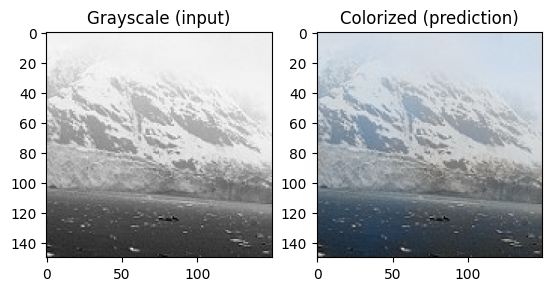

In [37]:
import matplotlib.pyplot as plt
import cv2

plt.subplot(1,2,1)
plt.title("Grayscale (input)")
plt.imshow(l_tensor.squeeze().cpu().numpy(), cmap="gray")   # (H,W)

plt.subplot(1,2,2)
plt.title("Colorized (prediction)")
# plt.imshow(cv2.cvtColor(rgb_pred, cv2.COLOR_BGR2RGB)) # (H,W,3)
plt.imshow(rgb_pred)

plt.show()
